In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

In [294]:
df = pd.read_csv('E-commerce Customer Behavior - Sheet1.csv')
df.head()

,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,Female,29,New York,Gold,1120.20,14,4.6,True,25,Satisfied
1,102,Male,34,Los Angeles,Silver,780.50,11,4.1,False,18,Neutral
2,103,Female,43,Chicago,Bronze,510.75,9,3.4,True,42,Unsatisfied
3,104,Male,30,San Francisco,Gold,1480.30,19,4.7,False,12,Satisfied
4,105,Male,27,Miami,Silver,720.40,13,4.0,True,55,Unsatisfied


In [295]:
print(f" df has {df.shape[0]} rows")
print(f" df has {df.shape[1]} cols")

 df has 350 rows
 df has 11 cols


In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               350 non-null    int64  
 1   Gender                    350 non-null    object 
 2   Age                       350 non-null    int64  
 3   City                      350 non-null    object 
 4   Membership Type           350 non-null    object 
 5   Total Spend               350 non-null    float64
 6   Items Purchased           350 non-null    int64  
 7   Average Rating            350 non-null    float64
 8   Discount Applied          350 non-null    bool   
 9   Days Since Last Purchase  350 non-null    int64  
 10  Satisfaction Level        348 non-null    object 
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 27.8+ KB


In [297]:
df.isna().sum()

Customer ID                 0
Gender                      0
Age                         0
City                        0
Membership Type             0
Total Spend                 0
Items Purchased             0
Average Rating              0
Discount Applied            0
Days Since Last Purchase    0
Satisfaction Level          2
dtype: int64

drop the rows with null (only 2 rows)

In [298]:
df = df.dropna()

In [299]:
print(df.isna().sum().sum())

0


Great! No null values.
Now, prepare the data for modeling.

# Process the data


In [300]:

def plot_categorical_distribution(column_name):
    value_counts = df[column_name].value_counts()

    plt.figure(figsize=(6, 4))
    plt.bar(value_counts.index, value_counts.values)
    plt.title(f'Distribution of {column_name}', fontsize=16)
    plt.xlabel(column_name, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

def plot_pie_chart(column_name):
    value_counts = df[column_name].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Percentage Distribution of {column_name}', fontsize=16)
    plt.show()
def plot_box_plot(numerical_col):
    plt.figure(figsize=(8, 6))
    df.boxplot(column=numerical_col)
    plt.title(f'{numerical_col}')
    plt.suptitle('')  # Suppress the default title
    plt.xlabel('Cluster')
    plt.ylabel(numerical_col)
    plt.show()

1. Gender

In [301]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

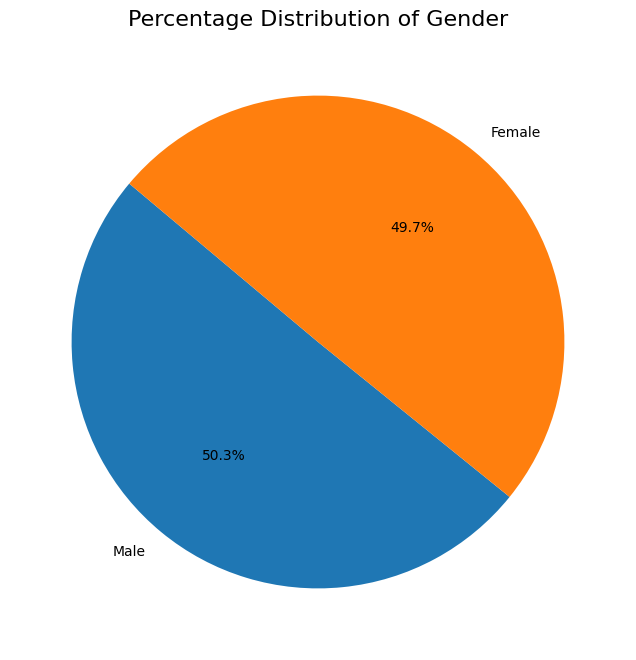

In [302]:

plot_pie_chart('Gender')

2. City

In [303]:
df['City'].unique()

array(['New York', 'Los Angeles', 'Chicago', 'San Francisco', 'Miami',
       'Houston'], dtype=object)

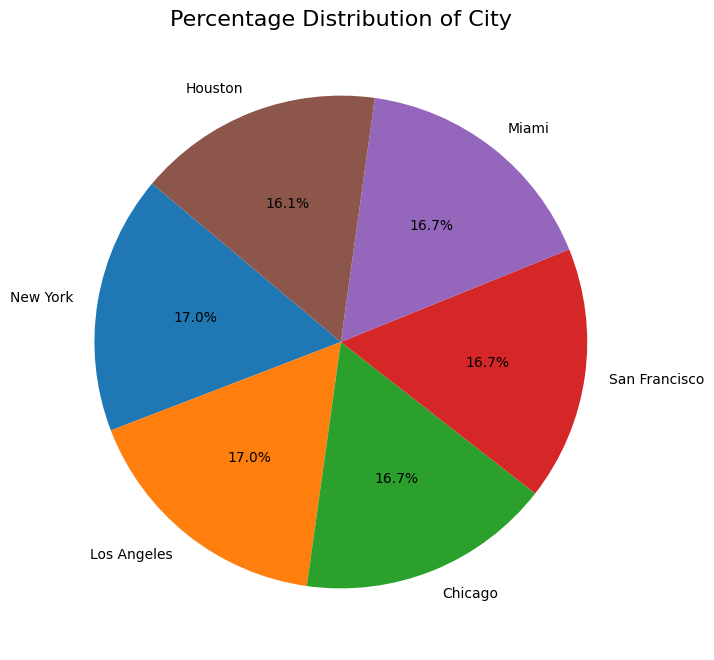

In [304]:
plot_pie_chart('City')

3. membership type

In [305]:
df['Membership Type'].unique()

array(['Gold', 'Silver', 'Bronze'], dtype=object)

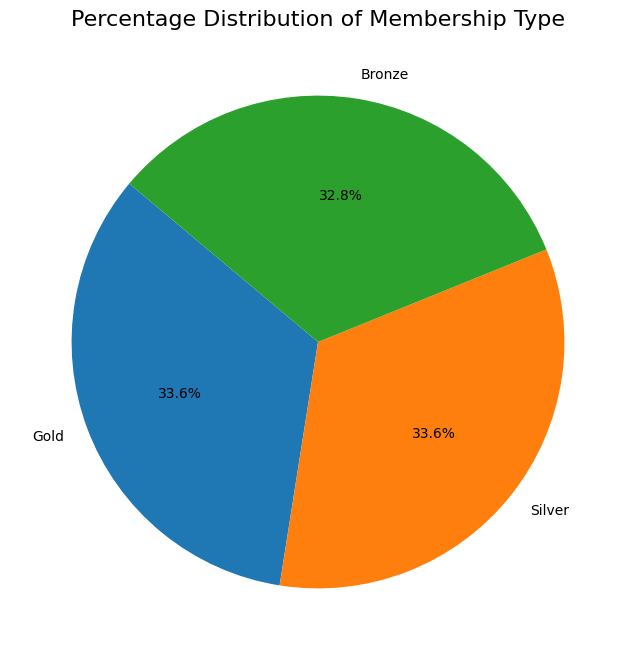

In [306]:
plot_pie_chart('Membership Type')

 Understand the level of satisfaction among the different membership type

In [307]:

membership_satisfaction = df.groupby(['Membership Type', 'Satisfaction Level'])['Customer ID'].count().unstack()
membership_satisfaction = membership_satisfaction.fillna(0)

In [308]:
def plot_grouped_bar_chart(groupby_obj):
    groupby_obj.plot(kind='bar', figsize=(10, 7), stacked=False)

    # Add labels and title
    plt.title('Satisfaction Level for Each Membership Type')
    plt.xlabel('Membership Type')
    plt.ylabel('Number of Customers')
    plt.legend(title='Satisfaction Level')

    # Show the plot
    plt.show()

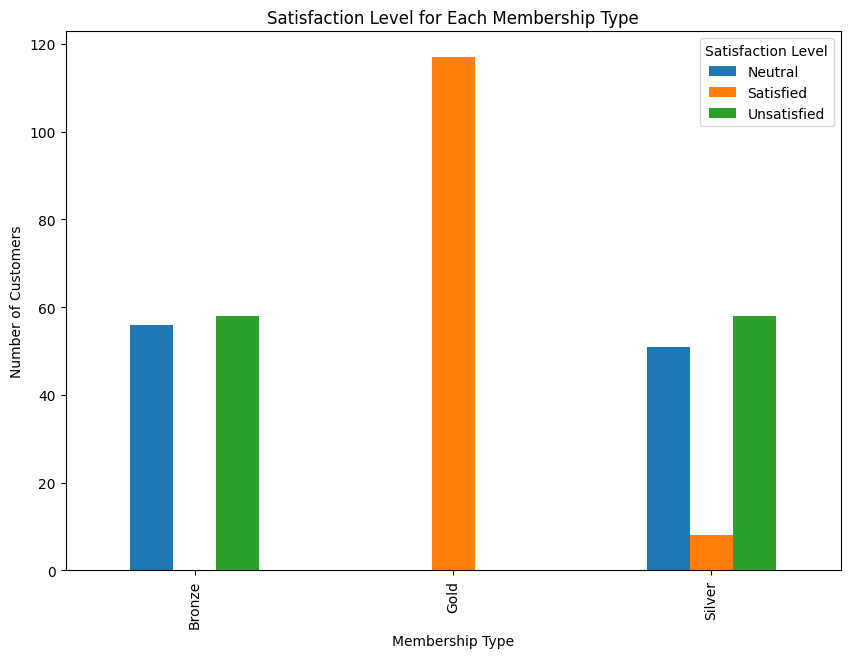

In [309]:
plot_grouped_bar_chart(membership_satisfaction)

Among the Bronze type, there is no even 1 satisfied customer.Silver typs, besides few satisfied customers, most of them neural or unsatsifed. This information can be used for improving the membership type, asjust them to increase the satisfaction level.

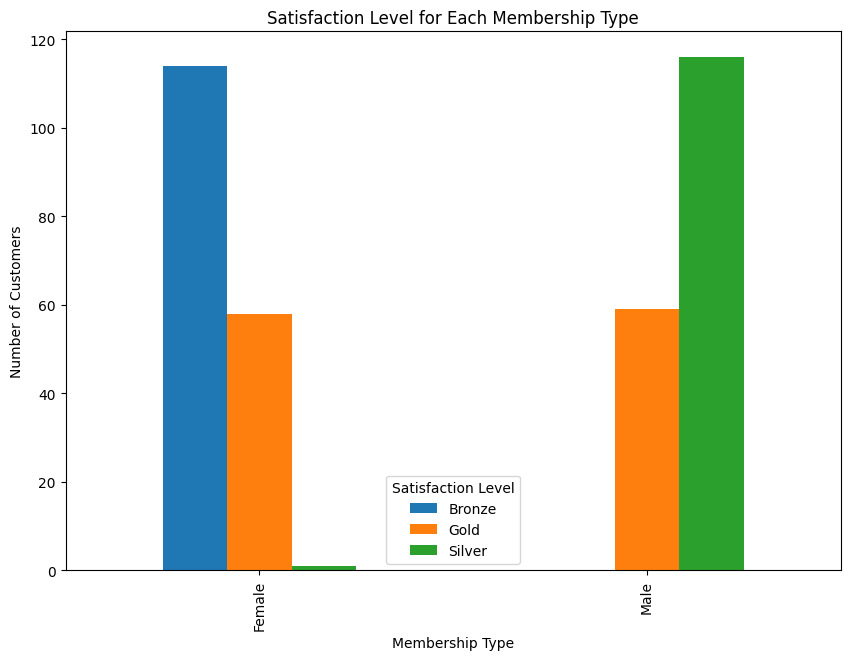

In [310]:

gender_membership = df.groupby(['Gender', 'Membership Type'])['Customer ID'].count().unstack()
gender_membership = gender_satisfaction.fillna(0)
plot_grouped_bar_chart(gender_membership)


In [311]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

In [312]:
df_numerical_cols = df[numerical_cols]

In [313]:
df_numerical_cols.set_index('Customer ID', inplace=True)
df_numerical_cols.describe()

,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase
count,348.000000,348.000000,348.000000,348.000000,348.000000
mean,33.577586,847.793103,12.632184,4.023563,26.614943
std,4.878024,361.692375,4.146079,0.579145,13.474750
min,26.000000,410.800000,7.000000,3.000000,9.000000
25%,30.000000,505.750000,9.000000,3.500000,15.000000
50%,32.000000,780.200000,12.000000,4.100000,23.000000
75%,37.000000,1160.600000,15.000000,4.500000,38.000000
max,43.000000,1520.100000,21.000000,4.900000,63.000000


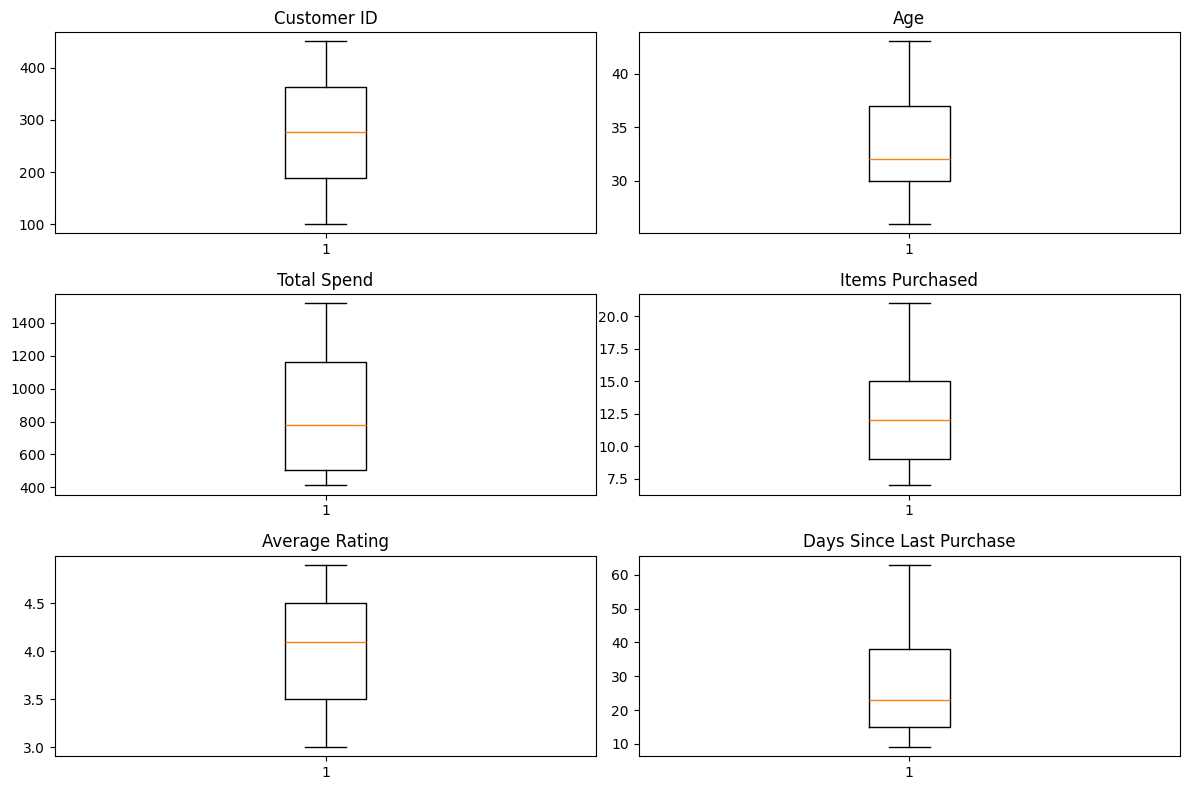

In [314]:
def plot_box_plots():
    n_rows, n_cols = 3, 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
    axes = axes.flatten()
    for i, col in enumerate(numerical_cols):
        axes[i].boxplot(df[col])
        axes[i].set_title(col)
    plt.tight_layout()
    plt.show()
plot_box_plots()

In [315]:
scaler = StandardScaler()
df_numerical_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_cols[1:]]), columns=numerical_cols[1:])
df_numerical_scaled

,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase
0,-0.939761,0.754230,0.330381,0.996757,-0.120022
1,0.086720,-0.186319,-0.394236,0.132172,-0.640260
2,1.934386,-0.933192,-0.877314,-1.078247,1.143413
3,-0.734465,1.751261,1.538076,1.169674,-1.086179
4,-1.350354,-0.352721,0.088842,-0.040745,2.109570
...,...,...,...,...,...
343,-0.323873,-0.519124,-0.635775,-0.386579,1.143413
344,0.497312,-1.044635,-1.118853,-1.769915,0.028617
345,-0.734465,0.949704,0.813459,0.823840,0.102937
346,0.086720,-0.187149,-0.394236,0.305089,-0.417301


In [316]:
df_numerical_scaled['Customer ID'] = df['Customer ID'].values
df_numerical_scaled

,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase,Customer ID
0,-0.939761,0.754230,0.330381,0.996757,-0.120022,101
1,0.086720,-0.186319,-0.394236,0.132172,-0.640260,102
2,1.934386,-0.933192,-0.877314,-1.078247,1.143413,103
3,-0.734465,1.751261,1.538076,1.169674,-1.086179,104
4,-1.350354,-0.352721,0.088842,-0.040745,2.109570,105
...,...,...,...,...,...,...
343,-0.323873,-0.519124,-0.635775,-0.386579,1.143413,446
344,0.497312,-1.044635,-1.118853,-1.769915,0.028617,447
345,-0.734465,0.949704,0.813459,0.823840,0.102937,448
346,0.086720,-0.187149,-0.394236,0.305089,-0.417301,449


In [317]:
df_numerical_scaled.set_index('Customer ID', inplace=True)

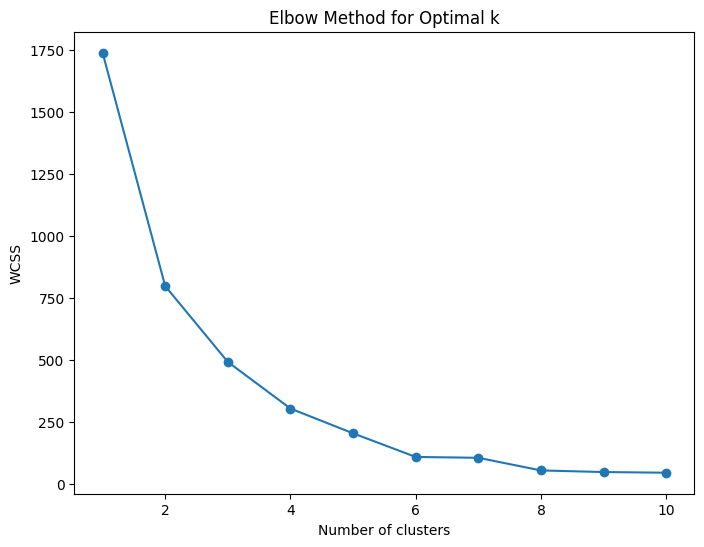

In [318]:
plot_elbow_method(df_numerical_scaled)

not very intutive so i will check the Silloutte score

In [319]:
df_numerical_scaled

,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase
Customer ID,,,,,
101,-0.939761,0.754230,0.330381,0.996757,-0.120022
102,0.086720,-0.186319,-0.394236,0.132172,-0.640260
103,1.934386,-0.933192,-0.877314,-1.078247,1.143413
104,-0.734465,1.751261,1.538076,1.169674,-1.086179
105,-1.350354,-0.352721,0.088842,-0.040745,2.109570
...,...,...,...,...,...
446,-0.323873,-0.519124,-0.635775,-0.386579,1.143413
447,0.497312,-1.044635,-1.118853,-1.769915,0.028617
448,-0.734465,0.949704,0.813459,0.823840,0.102937


## K Means

In [320]:
def plot_elbow_method(df_numerical, max_clusters=10):
    within_cluster_sum_of_square  = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(df_numerical)
        within_cluster_sum_of_square.append(kmeans.inertia_)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), within_cluster_sum_of_square, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()


In [321]:
kmeans = KMeans(n_clusters=3).fit(df_numerical_scaled)

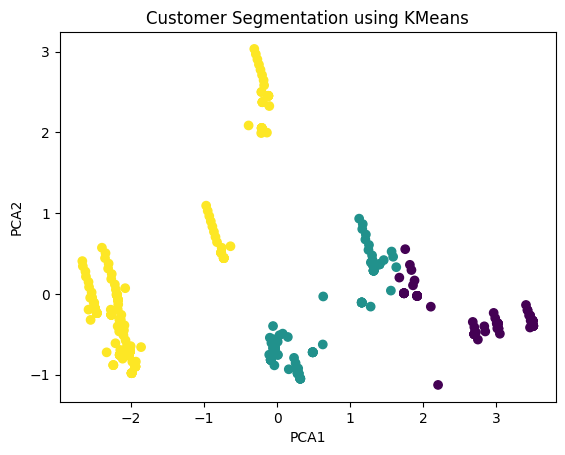

In [322]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df_numerical_scaled)

plt.scatter(pca_features[:, 0], pca_features[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Customer Segmentation using KMeans')
plt.show()


it was hrder to detrmine the K and maybe density based clutering algoritthm which does not requires specify the number of clusters will be better.

## DBSCAN

In [323]:
# Initialize DBSCAN with chosen parameters
dbscan = DBSCAN(eps=0.7, min_samples=5)

dbscan.fit(df_numerical_scaled)

# Get cluster labels
labels = dbscan.labels_


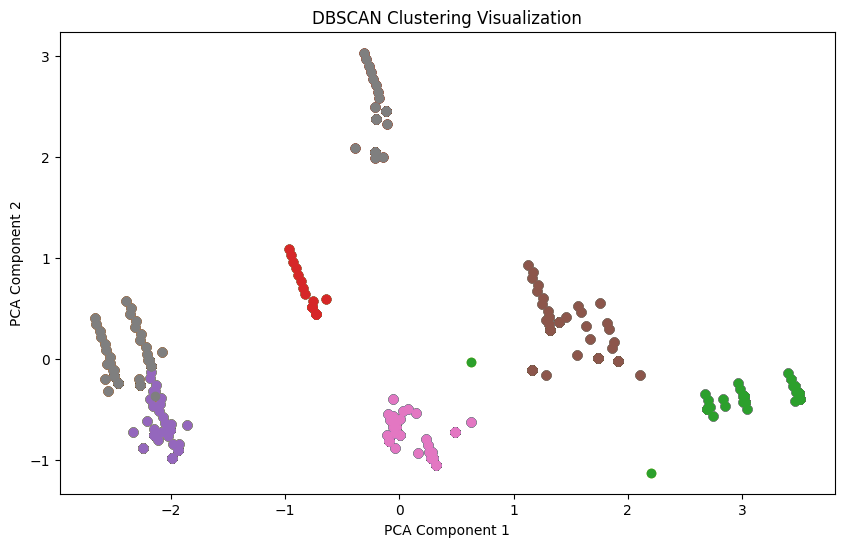

In [324]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df_numerical_scaled)

plt.figure(figsize=(10, 6))

for label in labels:
    cluster_points = pca_features[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {label}')
plt.title('DBSCAN Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


the DBSCAN shows much more cohernt clusters.

In [325]:
kmeans_df = df_numerical_cols
kmeans_df['k_means_cluster'] = kmeans.labels_
kmeans_df.groupby('k_means_cluster').mean()

C:\Users\User\AppData\Local\Temp\ipykernel_22264\632473645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmeans_df['k_means_cluster'] = kmeans.labels_


,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase
k_means_cluster,,,,,
0,29.367089,1387.891139,18.949367,4.760759,13.696203
1,32.927835,941.077320,12.917526,4.300000,19.773196
2,35.877907,547.116860,9.569767,3.529070,36.406977


In [326]:
dbscan_df = df_numerical_cols

dbscan_df['dbscan_cluster'] = dbscan.labels_

dbscan_df.groupby('dbscan_cluster').mean()

C:\Users\User\AppData\Local\Temp\ipykernel_22264\1900618632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbscan_df['dbscan_cluster'] = dbscan.labels_


,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase,k_means_cluster
dbscan_cluster,,,,,,
-1,31.500000,1100.850000,15.000000,4.400000,13.500000,0.500000
0,30.711864,1165.035593,15.271186,4.544068,24.593220,0.644068
1,34.241379,805.915517,11.689655,4.172414,15.258621,1.000000
2,42.017241,499.882759,9.413793,3.456897,40.465517,2.000000
3,29.000000,1460.456140,20.017544,4.812281,11.175439,0.000000
4,26.794118,703.688235,12.764706,4.017647,53.176471,2.000000
5,36.696429,447.648214,7.589286,3.191071,22.785714,2.000000
6,32.000000,671.550000,10.041667,3.800000,34.625000,2.000000
